In [2]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import krippendorff

In [3]:
# colors
demblue = "#0015BC"
repred = "#FF0000"
indgrey = "#696969"

# NewsGuard nutrition scores

In [4]:
# load the nutrition labels
src = "../../data/newsguard/newsguard_2022-03/03"
fname = "metadata-2022030100.csv"
NG_scores = pd.read_csv(join(src, fname))
# if more than one score exists for the same domain, keep the most recent one
NG_scores = NG_scores.sort_values(by=["Domain","Last Updated"], ascending=False)
NG_scores = NG_scores.drop_duplicates(subset=["Domain"])

# threshold scores at various cutoffs to define untrustworthy domains
NG_scores["fishy_60"] = 0
NG_scores["fishy_40"] = 0
NG_scores["fishy_20"] = 0
NG_scores.loc[NG_scores[NG_scores["Score"] < 60].index, "fishy_60"] = 1
fishy_60_domains = set(NG_scores[NG_scores["fishy_60"] == 1]["Domain"])
NG_scores.loc[NG_scores[NG_scores["Score"] < 40].index, "fishy_40"] = 1
fishy_40_domains = set(NG_scores[NG_scores["fishy_40"] == 1]["Domain"])
NG_scores.loc[NG_scores[NG_scores["Score"] < 20].index, "fishy_20"] = 1
fishy_20_domains = set(NG_scores[NG_scores["fishy_20"] == 1]["Domain"])

In [5]:
number_of_english_domains = NG_scores["Language"].value_counts().loc["en"]

untrustworthy_60 = len(NG_scores[(NG_scores["Language"] == "en") &\
                        (NG_scores["Score"] < 60)]) / \
                        len(NG_scores[NG_scores["Language"] == "en"])
untrustworthy_40 = len(NG_scores[(NG_scores["Language"] == "en") &\
                        (NG_scores["Score"] < 40)]) / \
                        len(NG_scores[NG_scores["Language"] == "en"])
untrustworthy_20 = len(NG_scores[(NG_scores["Language"] == "en") &\
                        (NG_scores["Score"] < 20)]) / \
                        len(NG_scores[NG_scores["Language"] == "en"])

print("The NewsGuard dataset as of 2022-03-01 contains {} english entries"\
        .format(number_of_english_domains))
print("{:1.2f} % ({}) of English entries have a score < 60"\
        .format(untrustworthy_60 * 100, len(fishy_60_domains)))
print("{:1.2f} % ({}) of English entries have a score < 40"\
        .format(untrustworthy_40 * 100, len(fishy_40_domains)))
print("{:1.2f} % ({}) of English entries have a score < 20"\
        .format(untrustworthy_20 * 100, len(fishy_20_domains)))

The NewsGuard dataset as of 2022-03-01 contains 6860 english entries
37.24 % (2757) of English entries have a score < 60
33.12 % (2428) of English entries have a score < 40
13.73 % (1029) of English entries have a score < 20


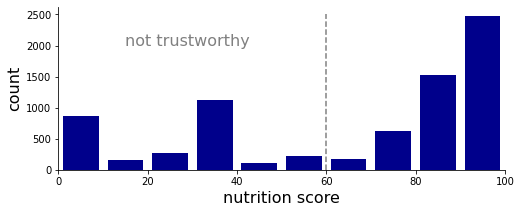

In [6]:
dst = "../../plots/"
fname = "newsguard_scores"
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(NG_scores["Score"], rwidth=0.8, color="DarkBlue")
ax.set_xlim(0, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("count", fontsize=16)
ax.set_xlabel("nutrition score", fontsize=16)
ax.plot([60, 60], [0, 2500], '--', color="grey")
ax.text(15, 2000, "not trustworthy", color="grey", fontsize=16)
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight")
plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight")

# Alternative trustworthiness labels

In [8]:
# load the list of independently compiled trustworthiness labels for 
# news sources
src = "../../data/twitter"
fname = "unstrustworthy_domain_list.csv"
alt_labels = pd.read_csv(join(src, fname))
alt_labels = alt_labels.rename(columns = {"type":"unreliable", "url":"Domain"})

# convert reliability labels to binary
alt_labels["unreliable"] = alt_labels["unreliable"]\
    .replace({"reliable":0, "unreliable":1})
N_alt_labels = len(alt_labels)
N_alt_untrustworthy = alt_labels["unreliable"].value_counts().loc[1]

In [ ]:
NG_domains = set(NG_scores["Domain"])
alt_domains = set(alt_labels["Domain"])
shared_domains = len(NG_domains.intersection(alt_domains))
untrustworthy_domains = set(alt_labels[alt_labels["unreliable"] == 1]["Domain"])
shared_untrustworthy_domains_60 = len(fishy_60_domains\
                                   .intersection(untrustworthy_domains))
shared_untrustworthy_domains_40 = len(fishy_40_domains\
                                   .intersection(untrustworthy_domains))
shared_untrustworthy_domains_20 = len(fishy_20_domains\
                                   .intersection(untrustworthy_domains))

In [34]:
print(f"The alternative list contains {N_alt_labels} domains")
print(f"Out of which {N_alt_untrustworthy} are labelled 'untrustworthy'")
print(f"{shared_domains} domains are also indexed by NewsGuard")
print(f"{shared_untrustworthy_domains_60} untrustworthy domains are also indexed by NewsGuard (score < 60)")
print(f"{shared_untrustworthy_domains_40} untrustworthy domains are also indexed by NewsGuard (score < 40)")
print(f"{shared_untrustworthy_domains_20} untrustworthy domains are also indexed by NewsGuard (score < 20)")

The alternative list contains 4767 domains
Out of which 2170 are labelled 'untrustworthy'
1677 domains are also indexed by NewsGuard
566 untrustworthy domains are also indexed by NewsGuard (score < 60)
507 untrustworthy domains are also indexed by NewsGuard (score < 40)
185 untrustworthy domains are also indexed by NewsGuard (score < 20)


# Comparison NewsGuard <-> alternative labels

In [9]:
alt_domains = set(alt_labels["Domain"])

In [10]:
len(alt_domains)

4767

In [11]:
alt_labels["unreliable"].value_counts()

0    2597
1    2170
Name: unreliable, dtype: int64

In [12]:
NG_domains = set(NG_scores["Domain"])

In [13]:
in_both = alt_domains.intersection(NG_domains)
len(in_both)

1677

In [14]:
alt_labels[alt_labels["Domain"].isin(list(NG_domains))]["unreliable"].value_counts()

0    1062
1     615
Name: unreliable, dtype: int64

In [15]:
alt_labels["unreliable"] = alt_labels["unreliable"].replace({
    "reliable":0,
    "unreliable":1
})

In [16]:
NG_scores["unreliable"] = 0
NG_scores.loc[NG_scores[NG_scores["Score"] < 60].index, "unreliable"] = 1

In [18]:
labels_NG = NG_scores[NG_scores["Domain"].isin(in_both)]\
    .sort_values(by="Domain")[["Domain", "unreliable"]]
labels_ind = alt_labels[alt_labels["Domain"].isin(in_both)]\
    .sort_values(by="Domain")[["Domain", "unreliable"]]
joint_labels = pd.DataFrame({
    "label_NG":labels_NG["unreliable"].values,
    "label_ind":labels_ind["unreliable"].values})

same = len(joint_labels[joint_labels["label_NG"] == joint_labels["label_ind"]])
kripp = krippendorff.alpha(joint_labels.transpose())
print(f"number of same labels: {same}, krippendorff's alpha: {kripp}")

number of same labels: 1553, krippendorff's alpha: 0.8422170341180256


# Shortened URLs

In [29]:
src = "../../data/twitter"
fname = "US_politician_tweets_2010-11-06_to_2022-03-16.csv.gzip"
tweets = pd.read_csv(join(src, fname), compression="gzip")

In [30]:
for score_cutoff in [60, 40, 20]:
    N_shortened = len(tweets[(tweets["shortened_url"] == True)])
    N_shortened_fishy = len(tweets[(tweets["shortened_url"] == True) & \
                                   (tweets[f"fishy_{score_cutoff}"] == 1)])
    print("{}/{} ({:1.2f}%) shortened domains are fishy ({})"\
          .format(N_shortened_fishy, N_shortened, 
                  (N_shortened_fishy / N_shortened) * 100, score_cutoff))

    N_unshortened = len(tweets[(tweets["shortened_url"] == False)])
    N_unshortened_fishy = len(tweets[(tweets["shortened_url"] == False) & \
                                     (tweets[f"fishy_{score_cutoff}"] == 1)])
    print("{}/{} ({:1.2f}%) unshortened domains are fishy ({})"\
          .format(N_unshortened_fishy, N_unshortened, 
                  (N_unshortened_fishy / N_unshortened) * 100, score_cutoff))
    print("**********")
print("{}/{} ({:1.2f}%) of links are shortened"\
      .format(N_shortened, N_shortened + N_unshortened,
              (N_shortened / (N_shortened + N_unshortened)) * 100))

1378/184223 (0.75%) shortened domains are fishy (60)
5503/2704305 (0.20%) unshortened domains are fishy (60)
**********
556/184223 (0.30%) shortened domains are fishy (40)
2215/2704305 (0.08%) unshortened domains are fishy (40)
**********
137/184223 (0.07%) shortened domains are fishy (20)
1023/2704305 (0.04%) unshortened domains are fishy (20)
**********
184223/2888528 (6.38%) of links are shortened


# Fishy links

In [31]:
nutrition_cols = [
    "fishy", "fishy_40", "fishy_20", "Domain",
    "Rating", "Score", "Country", "Language", 
    "Does not repeatedly publish false content",
    "Gathers and presents information responsibly",
    "Regularly corrects or clarifies errors",
    "Handles the difference between news and opinion responsibly",
    "Avoids deceptive headlines",
    "Website discloses ownership and financing",
    "Clearly labels advertising",
    "Reveals who's in charge, including any possible conflicts of interest",
    "The site provides names of content creators, along with either contact or biographical information"
]
nutrition_categories = {col:f"C_{i}" for i, col in enumerate(nutrition_cols[8:])}

In [36]:
fishy_user_count = tweets[["author_id", "fishy_60", "fishy_40", "fishy_20"] + \
    list(nutrition_categories.values())]\
    .groupby("author_id")\
    .agg(["sum", "count"])

fishy_user_count["fishy_share_60"] = fishy_user_count["fishy_60"]["sum"] / \
                            fishy_user_count["fishy_60"]["count"]
fishy_user_count["fishy_share_40"] = fishy_user_count["fishy_40"]["sum"] / \
                            fishy_user_count["fishy_40"]["count"]
fishy_user_count["fishy_share_20"] = fishy_user_count["fishy_20"]["sum"] / \
                            fishy_user_count["fishy_20"]["count"]

for col in nutrition_categories.values():
    fishy_user_count[f"{col}_share"] = fishy_user_count[col]["sum"] / \
                                       fishy_user_count[col]["count"]
    
# flatten the hierarchical indices
fishy_user_count = fishy_user_count.reset_index()
fishy_user_count.columns = ['_'.join(col).strip("_") \
                            for col in fishy_user_count.columns.values]

fishy_user_count.head(2)

,author_id,fishy_60_sum,fishy_60_count,fishy_40_sum,fishy_40_count,fishy_20_sum,fishy_20_count,C_0_sum,C_0_count,C_1_sum,...,fishy_share_20,C_0_share,C_1_share,C_2_share,C_3_share,C_4_share,C_5_share,C_6_share,C_7_share,C_8_share
0,4107251,6.0,1019,5.0,1019,0.0,1019,5.0,256,31.0,...,0.0,0.019531,0.121094,0.093750,0.164062,0.0,0.257812,0.091270,0.117188,0.152344
1,5558312,1.0,1361,0.0,1361,0.0,1361,0.0,319,24.0,...,0.0,0.000000,0.075235,0.090909,0.059561,0.0,0.078370,0.232484,0.278997,0.181818


In [43]:
for score_cutoff in [60, 40, 20]:
    N_no_shares = len(fishy_user_count[\
                    fishy_user_count[f"fishy_share_{score_cutoff}"] == 0])
    print("{}/{} did not share any fishy links ({})"\
             .format(N_no_shares, len(fishy_user_count), score_cutoff))

    max_share = fishy_user_count[f"fishy_share_{score_cutoff}"].max()
    print("the most fishy user has {:1.2f}% tweets with fishy links ({})"\
          .format(max_share * 100, score_cutoff))
    print("**********")

415/1035 did not share any fishy links (60)
the most fishy user has 9.71% tweets with fishy links (60)
**********
617/1035 did not share any fishy links (40)
the most fishy user has 4.81% tweets with fishy links (40)
**********
804/1035 did not share any fishy links (20)
the most fishy user has 2.95% tweets with fishy links (20)
**********


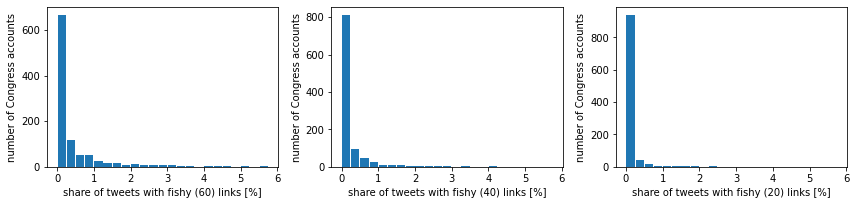

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for ax, col, add in zip(axes.flatten(), 
                        ["fishy_share_60", "fishy_share_40", "fishy_share_20"],
                        ["(60)", "(40)", "(20)"]):
    ax.hist(fishy_user_count[col] * 100, 
            bins=np.arange(0, 6, 0.25), rwidth=0.9)
    ax.set_xlabel(f"share of tweets with fishy {add} links [%]")
    ax.set_ylabel("number of Congress accounts")
fig.tight_layout()

In [46]:
nut_cat_dict = {
    "fishy": "domains with a NewsGuard\nscore of < 60",
    "fishy_40": "domains with a NewsGuard\nscore of < 40",
    "fishy_20":"domains with a NewsGuard\nscore of < 20",
    "C_0":"repeatedly publishes false information",
    "C_1":"doesn't gather and present\ninformation responsibly",
    "C_2":"doesn't regularly correct\nor clarify errors",
    "C_3":"doesn't handle the difference\nbetween news and opinion responsibly",
    "C_4":"uses deceptive headlines",
    "C_5":"doesn't disclose website\nownership and financing",
    "C_6":"doesn't label advertising",
    "C_7":"doesn't reveal conflicts\nof interest and who is in charge",
    "C_8":"doesn't provide names and\nbios of content creators"
}

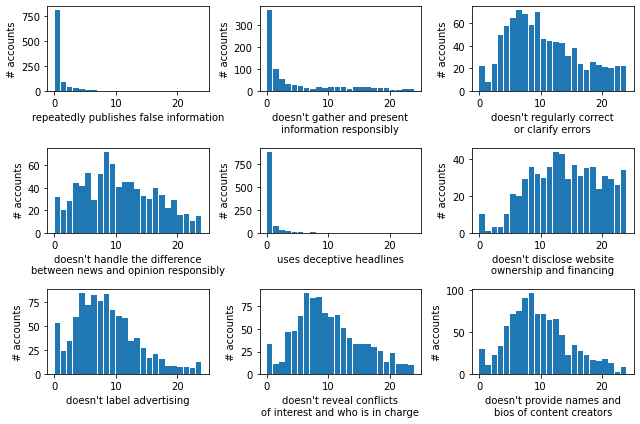

In [47]:
fig, axes = plt.subplots(3, 3, figsize=(9, 6))
for ax, col in zip(axes.flatten(), nutrition_categories.values()):
    ax.hist(fishy_user_count[f"{col}_share"] * 100, 
            bins=np.arange(0, 25, 1), rwidth=0.9)
    ax.set_xlabel(nut_cat_dict[col])
    ax.set_ylabel("# accounts")
fig.tight_layout()

In [48]:
del tweets

# Ideology scores

In [16]:
fname = "govtrack-stats-{}-{}-ideology.csv"
scores = pd.DataFrame()
for year in range(2013, 2021):
    for chamber in ["house", "senate"]:
        tmp = pd.read_csv(join(src, "ideology_scores",
                               fname.format(year, chamber)))
        tmp["year"] = year
        tmp["name"] = tmp["name"].apply(lambda x: x.replace("b'", ""))
        tmp["name"] = tmp["name"].apply(lambda x: x.replace("'", "").lower())
        scores = pd.concat([scores, tmp])

In [17]:
src = "../../data/twitter"
fname = "US_politician_twitter_account_stats_2010-11-06_to_2022-03-16.csv"
users = pd.read_csv(join(src, fname))

In [18]:
scores = pd.merge(scores, users[["party", "handle", "author_id", "ideology_score_id"]].drop_duplicates(subset=["ideology_score_id"]),
                  how="left", left_on="id", right_on="ideology_score_id")

In [19]:
scores = scores.sort_values(by=["handle", "year"])

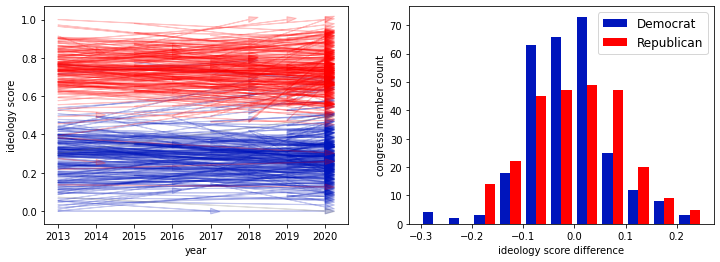

In [25]:
subset = scores.dropna(subset=["party"])
subset = subset.set_index("handle")
dem = subset[subset["party"] == "Democrat"]
rep = subset[subset["party"] == "Republican"]
ind = subset[subset["party"] == "Independent"]

diffs = pd.DataFrame(columns=["party", "ideology"])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
for dataset, color, party in zip([dem, rep, ind],
                                 [demblue, repred, indgrey],
                                 ["Democrat", "Republican", "Independent"]): 
    for handle in dataset.index.unique():
        user_data = dataset.loc[handle]
        if type(user_data) != pd.core.series.Series:
            x1 = user_data.iloc[0]["year"]
            x2 = user_data.iloc[-1]["year"] - x1
            y1 = user_data.iloc[0]["ideology"]
            y2 = user_data.iloc[-1]["ideology"] - y1
            
            diffs = pd.concat([diffs, pd.DataFrame({
                "party":[party],
                "ideology_difference":[y2]})])

        ax.arrow(x1, y1, x2, y2, color=color, alpha=0.2, 
                 width=0.001, head_width=0.03, head_length=0.25)
ax.set_ylabel("ideology score")
ax.set_xlabel("year")
        
ax = axes[1]
dem = diffs[diffs["party"] == "Democrat"]
rep = diffs[diffs["party"] == "Republican"]
ind = diffs[diffs["party"] == "Independent"]

ax.hist([dem["ideology_difference"], rep["ideology_difference"]],
        color=[demblue, repred], bins=np.arange(-0.3, 0.3, 0.05),
        label=["Democrat", "Republican"])
ax.set_ylabel("congress member count")
ax.set_xlabel("ideology score difference")
ax.legend(fontsize=12)

In [26]:
diffs.groupby("party").agg("mean")

,ideology_difference
party,
Democrat,-0.007680
Independent,0.057141
Republican,0.002842


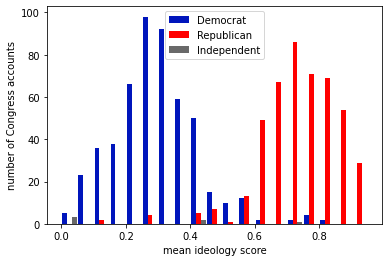

In [28]:
fig, ax = plt.subplots()
dem = users[users["party"] == "Democrat"]
rep = users[users["party"] == "Republican"]
ind = users[users["party"] == "Independent"]
ax.hist([dem["ideology_mean"], rep["ideology_mean"], ind["ideology_mean"]], 
        bins=np.arange(0, 1, 0.05), rwidth=0.9, 
        label=["Democrat", "Republican", "Independent"],
        color=[demblue, repred, indgrey])
ax.set_xlabel("mean ideology score")
ax.set_ylabel("number of Congress accounts")
ax.legend();